<a href="https://colab.research.google.com/github/junhuk1113/AIAD_weather/blob/master/Convlstm_model_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download and load the dataset.
"""
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
"""
fpath = "/content/drive/MyDrive/PBL_Shared_Data/202101cldcr200re64new.npy"
dataset = np.load(fpath)
print(dataset.shape)
# Swap the axes representing the number of frames and number of data samples.
#dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
#dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
#np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

(31, 24, 64, 64)
Training Dataset Shapes: (27, 23, 64, 64, 1), (27, 23, 64, 64, 1)
Validation Dataset Shapes: (4, 23, 64, 64, 1), (4, 23, 64, 64, 1)


Displaying frames for example 12.


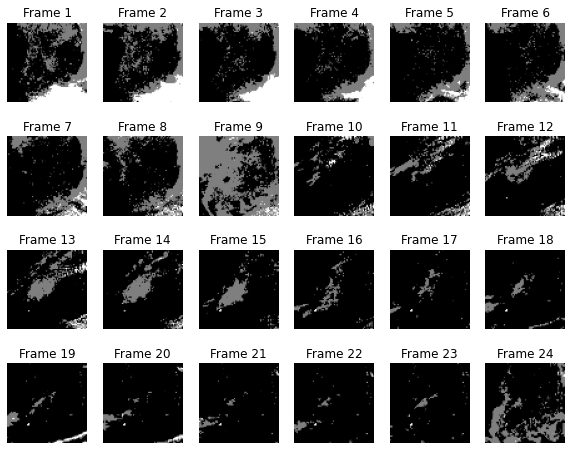

In [4]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 6, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [5]:
def model_gen(fs, ks):
  inp = layers.Input(shape=(None, *x_train.shape[2:]))
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  x = layers.ConvLSTM2D(
      filters=fs,
      kernel_size=(ks[0],ks[0]),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(inp)
  x = layers.BatchNormalization()(x)
  x = layers.ConvLSTM2D(
      filters=fs,
      kernel_size=(ks[1],ks[1]),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ConvLSTM2D(
      filters=fs,
      kernel_size=(ks[2],ks[2]),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.Conv3D(
      filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
  )(x)

  # Next, we will build the complete model and compile it.
  
  return inp, x

In [ ]:
kernels = [[5,3,1],[4,2,1],[3,2,1],[6,3,1]]
filters = [16,32,64]
batchs = [4,5,8,16,32]
for fs in filters:
  for ks in kernels:
    for batch_size in batchs:
      inp, x = model_gen(fs, ks)
      model = keras.models.Model(inp, x)
      model.compile(
            loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
        )

      # Define some callbacks to improve training.
      early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
      reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

      # Define modifiable training hyperparameters.
      epochs = 500

        # Fit the model to the training data.
      model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
      modelname = f"filter_{fs}_kernel_{ks}_batch_{batch_size}"
      #print(modelname)
      model.save(modelname+".h5")


In [ ]:
import subprocess

for fs in filters:
  for ks in kernels:
    for batch_size in batchs:
      
      modelname = f"filter_{fs}_kernel_{ks}_batch_{batch_size}"
      cmd = "cp -r " + "\"" +modelname+"\" "+"\"/content/drive/MyDrive/models/"+modelname+"\""
      print(cmd)
      subprocess.call(cmd,shell=True)

In [ ]:
from google.colab import files
f = files.upload()